In [1]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 856.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=30b191af543967937ad21945e5f1f478ecb994573db23f9bd94fe35d0cd27ae8
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
def get_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

In [22]:
symbol = 'IOC.NS'
start_date = '2020-01-01'
end_date = '2024-01-01'

In [23]:
def generate_signals(data):
    signals = pd.DataFrame(index=data.index)
    signals['Short_EMA'] = ta.ema(data['Close'], length=20)
    signals['Long_EMA'] = ta.ema(data['Close'], length=50)
    signals['RSI'] = ta.rsi(data['Close'], length=14)

    # Generate trading signals
    signals['Signal'] = 0
    signals.loc[signals['Short_EMA'] > signals['Long_EMA'], 'Signal'] = 1  # Buy signal
    signals.loc[signals['Short_EMA'] < signals['Long_EMA'], 'Signal'] = -1  # Short signal

    # Exit signals
    signals['Exit_Signal'] = 0
    signals.loc[(signals['RSI'] > 70) & (signals['Signal'] == 1), 'Exit_Signal'] = 1  # Exit long
    signals.loc[(signals['RSI'] < 30) & (signals['Signal'] == -1), 'Exit_Signal'] = -1  # Exit short

    return signals

In [24]:
def calculate_pnl(data, signals, initial_capital=100000000, compound=True):
    positions = pd.DataFrame(index=data.index)
    positions['Position'] = signals['Signal']
    positions['Stock'] = 1000 * positions['Position']

    # Daily portfolio value
    portfolio = positions.multiply(data['Close'], axis=0)
    pos_diff = positions.diff()

    # Add cash holdings to the portfolio
    portfolio['Cash'] = initial_capital - (pos_diff['Stock'] * data['Close']).cumsum()

    # Total portfolio value
    portfolio['Total'] = portfolio['Stock'] + portfolio['Cash']

    # Daily returns
    portfolio['Returns'] = portfolio['Total'].pct_change()

    if compound:
        portfolio['Returns'] = (1 + portfolio['Returns']).cumprod() - 1

    return portfolio

In [25]:
def plot_results(data, signals, pnl):

    plt.style.use('seaborn-darkgrid')

    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

    # Plotting Cumulative PnL (Equity Curve)
    axes[0].plot(pnl['Total'][49:], label='Cumulative PnL (Equity Curve)', color='purple')
    axes[0].set_title('Cumulative PnL (Equity Curve)')
    axes[0].legend(loc='upper left')

    # Plotting Drawdown Chart
    drawdown = (pnl["Total"][49:] / pnl["Total"][49:].cummax() - 1) * 100
    axes[1].plot(drawdown, label='Drawdown', color='red')
    axes[1].set_title('Drawdown Chart')
    axes[1].legend(loc='upper left')

    # Plotting Volatility (rolling standard deviation of daily returns)
    axes[2].plot(pnl["Returns"][49:].rolling(window=20).std(), label='Volatility', color='orange')
    axes[2].set_title('Volatility')
    axes[2].legend(loc='upper left')

    # # Add a common x-axis label
    # fig.text(0.5, 0.04, 'Date', ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()


In [26]:
stock_data = get_stock_data(symbol, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


<ipython-input-25-126752ce714a>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


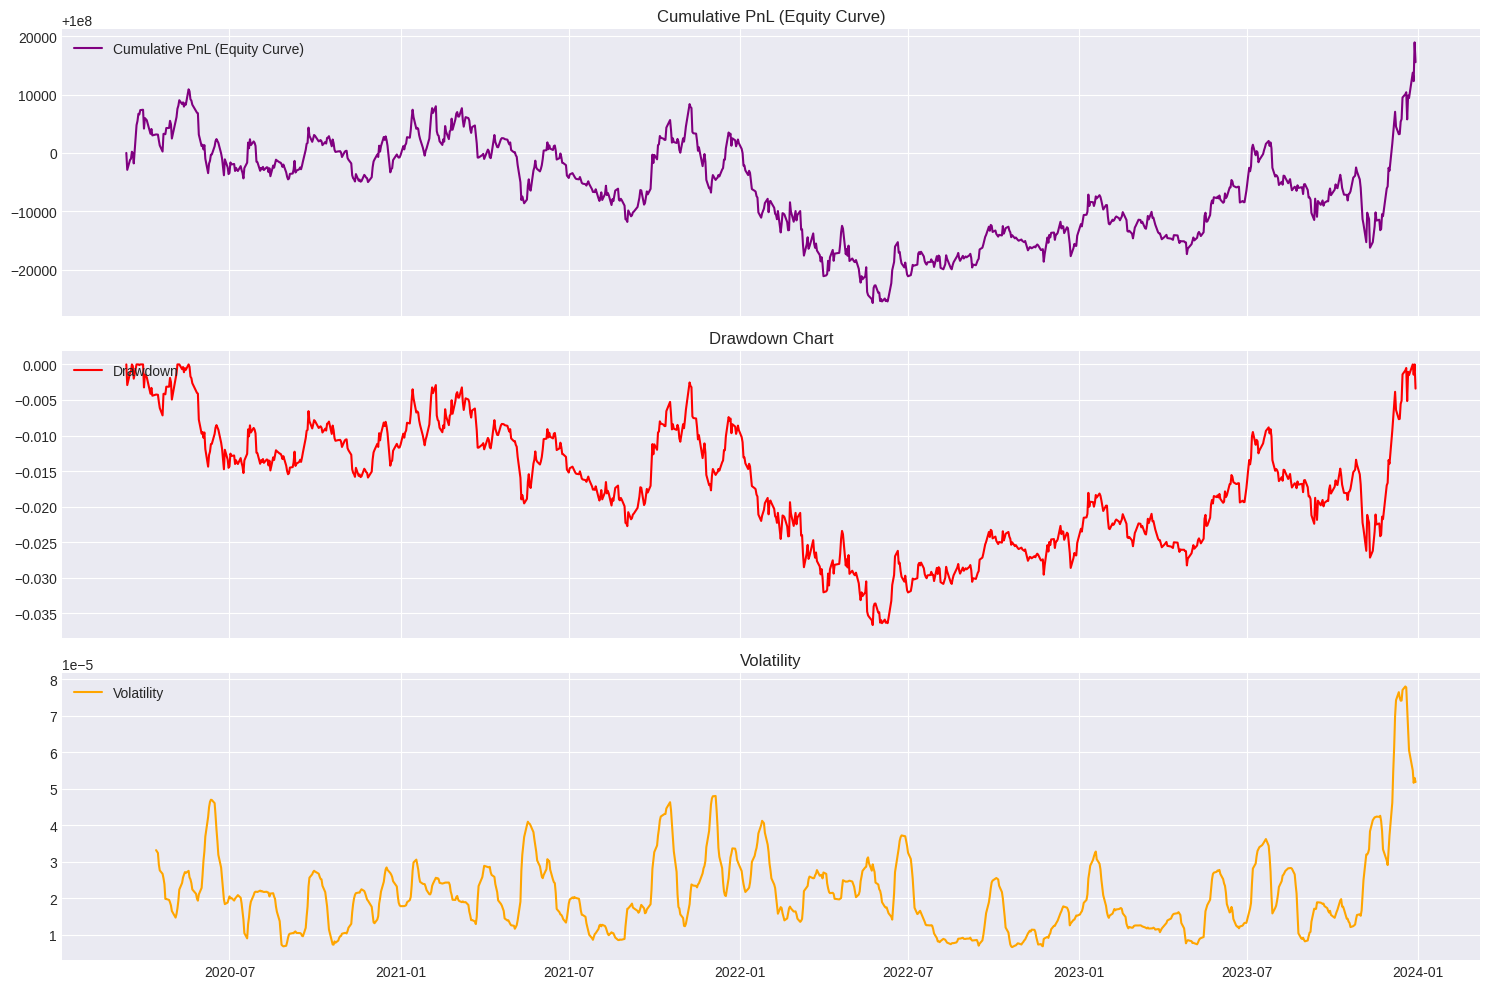

In [27]:
signals = generate_signals(stock_data)

pnl = calculate_pnl(stock_data, signals)

# Plot results
plot_results(stock_data, signals, pnl)